## Postprocess SWAT Simulations (2) - Runoff Change

As mentioned in the tutorial of [A Toolchain for Training Hydrological Modeling under Climate Change based on SWAT](https://www.linkedin.com/pulse/toolchain-training-hydrological-modeling-under-climate-chonghua-yin/), we know that the tool of [SWAT Output Viewer](https://swatviewer.com/) is excellent at managing multiple SWAT simulation scenarios through storing all data in SQLite databases.

Since we already know how to post-process SWAT simulation by SQLite and Pandas in this [tutorial](https://www.linkedin.com/pulse/postprocess-swat-simulations-sqlite-pandas-1-runoff-chonghua-yin/), it is very easy to calculate seasonal mean runoff changes between different SWAT scenarios, which is a common approach to assess the impacts of climate change on hydrological processes.

In this notebook, we put some codes from the [previous one](https://www.linkedin.com/pulse/postprocess-swat-simulations-sqlite-pandas-1-runoff-chonghua-yin/) into functions to simplify to query SQLite databases and calculate seasonal statistics. Even so, it is still better to go through the previous notebook that shows the basic postprocessing procedure step by step.

*It is worth noting that all data in this series are fake data and only are used to show how to post-process SWAT simulations through open source tools.*

## 1. Load all needed libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## 2. Calculate seasonal mean runoff changes

To simplify reading, we put the code into a function. Moreover, we only used the RCH table. 

In [2]:
def read_rch(db_name):
    con = sqlite3.connect(db_name)
    cursor = con.cursor()

    df = pd.read_sql_query("SELECT RCH, YR, MO, FLOW_OUTcms from rch", con)
    df = df.set_index(['MO'])
    con.close()
    return df

In addition, we only care about seasonal changes. Therefore, have to convert monthly data into seasonal means.

In [3]:
def calculate_ssnmean(df):
    quarters = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA',
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}
    ssndf = df.groupby(['RCH',quarters])['FLOW_OUTcms'].mean()
    ssndf = ssndf.reset_index()
    ssndf.set_index(['RCH'])
    ssndf = ssndf.rename(index=str, columns={"level_1":"SSN"})
    pivoted = ssndf.pivot(index='RCH', columns='SSN', values='FLOW_OUTcms')
    return pivoted

### 2.1 Read Baseline runoff

In [4]:
db_name = 'data\\baseline\\result_664_monthly.db3'
df_bsl = read_rch(db_name)
df_bsl.head()

,RCH,YR,FLOW_OUTcms
MO,,,
1,1,1981,146.252487
1,2,1981,96.182854
1,3,1981,11.861368
1,4,1981,49.406513
1,5,1981,272.106018


### 2.2 Read runoff in future

In [5]:
db_name = 'data\\future\\result_664_monthly.db3'
df_fut = read_rch(db_name)
df_fut.head()

,RCH,YR,FLOW_OUTcms
MO,,,
1,1,1981,133.313675
1,2,1981,87.963867
1,3,1981,8.715598
1,4,1981,44.826962
1,5,1981,257.170776


### 2.3 Calculate seasonal mean runoff

In [6]:
pivoted_bsl = calculate_ssnmean(df_bsl)
pivoted_fut = calculate_ssnmean(df_fut)
print(pivoted_fut.head())
print(pivoted_bsl.head())

SSN         DJF          JJA          MAM         SON
RCH                                                  
1     87.643939  1347.443983   713.695934  384.962918
2     45.715684   762.344993   281.216780  252.879492
3     54.120251   148.082089   378.022691   24.557090
4     22.645753   577.105851   361.976762  131.144510
5    346.533086  1555.323420  1360.550300  426.599176
SSN         DJF          JJA          MAM         SON
RCH                                                  
1     99.204991  1405.262298   559.746932  454.737985
2     56.328539   773.664280   203.242828  297.934326
3     32.838328   166.310382   379.771358   27.425488
4     28.384519   619.184517   278.996801  155.766145
5    336.824441  1635.518864  1215.423962  499.265579


### 2.4 Calculate seasonal changes

In [7]:
pivoted_ch = (pivoted_fut - pivoted_bsl)/pivoted_bsl*100.0
pivoted_ch.head()

SSN,DJF,JJA,MAM,SON
RCH,,,,
1,-11.653700,-4.114414,27.503322,-15.344016
2,-18.840992,-1.463075,38.364922,-15.122405
3,64.808181,-10.960406,-0.460453,-10.458876
4,-20.217946,-6.795820,29.742263,-15.806795
5,2.882405,-4.903364,11.940388,-14.554659


## 3. Visualize

Set some parameters to make figure pretty

In [8]:
# Plot size to 15" x 7"
matplotlib.rc('figure', figsize = (15, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

Text(0,0.5,'Runoff Change (%)')

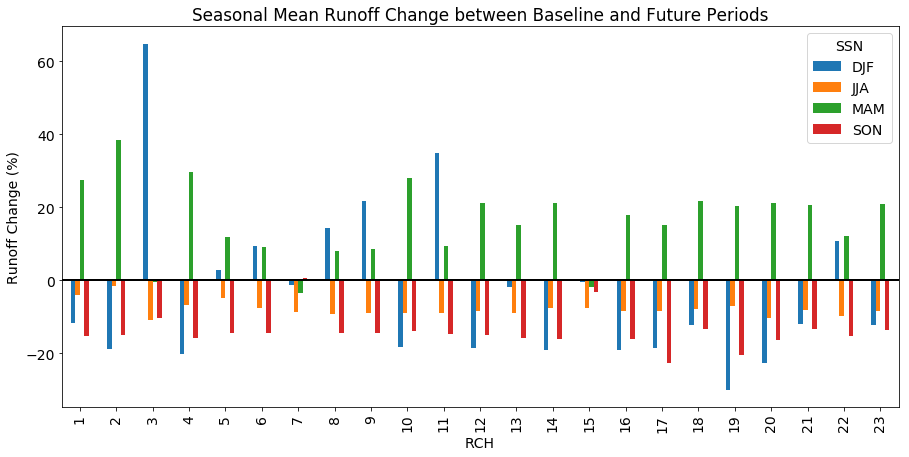

In [9]:
ax = pivoted_ch.plot(kind='bar',                    
             title='Seasonal Mean Runoff Change between Baseline and Future Periods')
ax.axhline(y=0, xmin=-1, xmax=1, color='k', lw=2)
ax.set_ylabel('Runoff Change (%)')

## References

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

https://www.sqlite.org/lang.html